<div align="center">
    <img alt="Institut Polytechnique de Paris Logo" width="auto" height="150px" src="https://www.ip-paris.fr/sites/default/files/presse/Charte%20Graphique/Logo%20IP%20Paris%206%20%C3%A9coles%20vertical%20png.png" />
</div>

<div style="text-align: center; font-family: Arial, sans-serif; margin: 20px 0;">
    <h1 style="font-size: 32px; margin-bottom: 10px;">Language Models & Retrieval Augmented Generation Lab</h1>
    <p style="font-size: 16px; margin: 0;">Authors: 
        <strong>Tim Luka Horstmann</strong> & <strong>William Liaw</strong>
    </p>
</div>

> **Now your Turn!**
> 
> Extend the previous code for multiple choice question answering according to the dataset provided [here](https://github.com/BunsenFeng/Knowledge_Card/blob/main/eval_datasets/MidtermQA/MidtermQA-fourchoice.json) (use first 100 questions from the "testset" for evaluation and use the "demo" for making sure that your pipeline is running).
> 
> - For each question and answers use [Spacy](https://spacy.io/) for Named Entity Recognition
> - For retrieving Wikipedia URLs use [Wikipedia API](https://pypi.org/project/Wikipedia-API/)
> - Extend the code from previous block to deal with multiple urls
> - Report the answers of the questions with and with out Retrieval Augmented Generation pipeline
> - Report the accuracy with and with out Retrieval Augmented Generation pipeline

## Colab compatibility

We opted to execute this code locally so the following cells were not needed. For convenience we made them available as to allow users to easily switch for the Google Colab environment.

In [ ]:
# !pip install colab-xterm
# !pip -qq install langchain
# !pip -qq install langchain-core
# !pip -qq install langchain-community
# !pip install ollama langchain beautifulsoup4 chromadb gradio -q

In [ ]:
# %load_ext colabxterm

```bash
curl -fsSL https://ollama.com/install.sh | sh
ollama serve & ollama pull llama3 & ollama pull nomic-embed-text
```

In [ ]:
# %xterm

## Module imports

In [ ]:
import json
import re
from difflib import SequenceMatcher

import matplotlib.pyplot as plt
import numpy as np
import ollama
import requests
import spacy
import wikipediaapi
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import Chroma
from tqdm.notebook import tqdm

## Global Variables

In [ ]:
DATA_PATH = "MidtermQA-fourchoice.json"
MAX_TEXTS_TO_KEEP = 5

# Optional variable for comprehensive logs
DEBUG = True

## Config & Models

In [ ]:
# Load SpaCy NER model
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_md")
# nlp = spacy.load("en_core_web_trf")

# Initialize Wikipedia API
wiki_wiki = wikipediaapi.Wikipedia(
    language="en",
    user_agent="MyProjectName (merlin@example.com)",  # Replace with your project/contact details
)

# Initialize Ollama embeddings (for retrieval)
embeddings = OllamaEmbeddings(model="nomic-embed-text")

/tmp/ipykernel_76240/3123207793.py:13: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(model="nomic-embed-text")


## Caching Functionality

<div style="border: 2px solid orange; background-color: #f9c74f; width: 800px; padding: 15px; border-radius: 8px; font-family: Arial, sans-serif; color: black;">

⚠️ <strong>Execute the following cell to clear <span style="color: #d9534f;">"cache"</span>.</strong>

</div>

In [ ]:
# For speeding up repeated Wikipedia fetches:
_wiki_cache = {}

## Functions

In [ ]:
def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, "r") as file:
        return json.load(file)


def decompose_question(input_text):
    if "?\n" not in input_text:
        return {"question": input_text.strip(), "options": {}}

    question_part, answers_part = input_text.split("?\n", 1)
    question = question_part.strip() + "?"

    options_list = re.split(r"([ABCD]\.)", answers_part)
    options = {}

    for i in range(1, len(options_list) - 1, 2):
        letter = options_list[i].replace(".", "").strip()
        text = options_list[i + 1].strip()
        options[letter] = text

    return {"question": question, "options": options}


def unify_duplicates(options_dict, gold_answer=None):
    """
    Unify duplicate option texts in 'options_dict'.
    If 'gold_answer' is provided, we also re-map the gold label if it's pointing to a duplicate.
    Returns (new_options_dict, new_gold_answer).
    """
    new_options = {}
    used_texts = {}
    remapped_gold = gold_answer

    for letter, text in options_dict.items():
        if text not in used_texts:
            new_options[letter] = text
            used_texts[text] = letter
        else:
            existing_letter = used_texts[text]
            if gold_answer == letter:
                remapped_gold = existing_letter

    return new_options, remapped_gold


def cosine_similarity(vec1, vec2):
    """Simple utility for cosine similarity between two lists of floats."""
    dot = sum(a * b for a, b in zip(vec1, vec2))
    mag1 = sum(a * a for a in vec1) ** 0.5
    mag2 = sum(b * b for b in vec2) ** 0.5
    return dot / (mag1 * mag2 + 1e-10)


def filter_by_relevance(wiki_texts, question, max_texts=3):
    """
    Given a list of wiki_texts (each a string), embed them, measure similarity
    to 'question', and keep the top 'max_texts'.
    """
    if not wiki_texts:
        return []

    question_embedding = embeddings.embed_query(question)
    scored_texts = []
    for text in wiki_texts:
        text_embedding = embeddings.embed_query(text)
        score = cosine_similarity(question_embedding, text_embedding)
        scored_texts.append((score, text))

    scored_texts.sort(key=lambda x: x[0], reverse=True)
    top_texts = [s[1] for s in scored_texts[:max_texts]]
    return top_texts


def build_vectorstore(wiki_texts, chunk_size=1500, chunk_overlap=100):
    """
    Build a Chroma VectorStore from a list of texts.
    Handles both single and multiple texts.
    """
    docs = []
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    for text in wiki_texts:
        doc = Document(page_content=text)
        split_docs = splitter.split_documents([doc])
        docs.extend(split_docs)
    vectorstore = Chroma.from_documents(docs, embedding=embeddings)

    return vectorstore.as_retriever()


def match_llm_to_option(llm_answer, options):
    """
    Fallback approach: match the LLM textual response to the best option via substring similarity.
    """
    best_score = 0.0
    best_option = None
    for letter, text in options.items():
        score = SequenceMatcher(None, llm_answer.lower(), text.lower()).ratio()
        if score > best_score:
            best_score = score
            best_option = letter

    return best_option if best_option else "A"


def ollama_llm(question, options, context="", use_context=True, debug=False):
    """
    Calls the Ollama LLM.
    If use_context=True, we provide a prompt instructing the LLM to answer only with
    the provided context.
    """
    options_str = "\n".join([f"{k}: {v}" for k, v in options.items()])
    if use_context:
        prompt = (
            "You are an expert on the 2022 U.S. midterm elections. "
            "Below is some CONTEXT, followed by a QUESTION and multiple-choice OPTIONS.\n\n"
            f"CONTEXT:\n{context}\n\n"
            f"QUESTION: {question}\n\n"
            f"OPTIONS:\n{options_str}\n\n"
            "Identify the best option (A, B, C, or D) based on the CONTEXT. "
            "If the context is unclear, use your best reasoning. "
            "Answer only with a single letter."
        )
    else:
        prompt = (
            "You are an expert on the 2022 U.S. midterm elections. "
            "Below is a QUESTION and multiple-choice OPTIONS.\n\n"
            f"QUESTION: {question}\n\n"
            f"OPTIONS:\n{options_str}\n\n"
            "Pick the correct option (A, B, C, or D) to the best of your knowledge. "
            "Answer only with a single letter."
        )

    if debug:
        print(f"[LLM PROMPT]---\n{prompt}\n---")

    response = ollama.chat(
        model="llama3", messages=[{"role": "user", "content": prompt}]
    )
    answer_text = response["message"]["content"].strip()

    if debug:
        print(f"[LLM RAW ANSWER]: {answer_text}")

    match = re.search(r"\b([ABCD])\b", answer_text, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    else:
        return match_llm_to_option(answer_text, options)


def evaluate_accuracy(predictions):
    """Computes accuracy from predictions which are dicts with 'pred_answer' and 'gold_answer'."""
    correct = 0
    total = 0
    for p in predictions:
        gold = p["gold_answer"]
        pred = p["pred_answer"]
        if gold and pred:
            total += 1
            if pred.strip().upper() == gold.strip().upper():
                correct += 1
    accuracy = (correct / total) if total > 0 else 0
    return accuracy


def _get_page_text(entity, debug=False):
    """
    Fetch the text of a Wikipedia page for a given entity.
    """
    page = wiki_wiki.page(entity)
    if page.exists():
        if debug:
            print(f"[PAGE FOUND] Wikipedia page for: {entity}")
        # return page.text
        return page.summary
    else:
        if debug:
            print(f"[PAGE NOT FOUND] No exact page for: {entity}")
        return None


def _search_best_match(entity, debug=False):
    """
    Use Wikipedia's search API to find the best match for an entity.
    """
    search_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "list": "search",
        "srsearch": entity,
        "format": "json",
    }

    try:
        response = requests.get(search_url, params=params, timeout=30)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        if debug:
            print(f"[ERROR] Search API request failed: {e}")
        return None

    search_results = response.json().get("query", {}).get("search", [])
    if not search_results:
        if debug:
            print(f"[SEARCH FAILED] No results found for: {entity}")
        return None

    best_match = search_results[0]["title"]
    if debug:
        print(f"[MATCH FOUND] '{entity}' matched with '{best_match}'.")
    return best_match


def fetch_wikipedia_content(entity, debug=False):
    """
    Fetch the first text paragraph from Wikipedia for a given entity.
    Uses Wikipedia's search API to find the best match if the exact page does not exist.
    """
    global _wiki_cache

    if entity in _wiki_cache:
        if debug:
            print(f"[CACHE HIT] Wikipedia text for: {entity}")
        return _wiki_cache[entity]

    text = _get_page_text(entity, debug)
    if text:
        _wiki_cache[entity] = text
        return text

    best_match = _search_best_match(entity, debug)
    if best_match:
        text = _get_page_text(best_match, debug)
        if text:
            _wiki_cache[entity] = text
            return text

    if debug:
        print(f"[SEARCH FAILED] No suitable match found for: {entity}")
    _wiki_cache[entity] = None
    return None


def parse_winner_district(question_text):
    """
    Extract congressional district phrases from the question.
    Handles both numbered and 'at-large' districts.
    """
    pattern = r"won the (.*? in the 2022)"
    matches = re.findall(pattern, question_text, re.IGNORECASE)

    return matches


def perform_ner_and_fetch_docs(records, debug=False, target_labels=None):
    """
    1. Perform NER on question and multiple-choice options
    2. Fetch relevant texts from Wikipedia
    3. Filter the texts by relevance
    4. Build a mini-retrieval store
    5. Return data with combined context
    """
    if target_labels is None:
        target_labels = {
            # As the questions are all concerning persons,
            # we choose to keep only a few tags
            "PERSON",
            "GPE",
            # "ORG",
            # "EVENT",
            "LOC",
            "NORP",
            # "ORDINAL",
        }
    GENERIC_ENTITIES = {"u.s.", "senate", "america", "united states"}

    final_data = []
    for entry in tqdm(records, desc="Performing NER & Wiki fetch", total=len(records)):
        raw_question = entry["question"]
        gold_answer = entry.get("answer", "").strip().upper()
        qid = entry["id"]

        # Extract question & options
        q_decomp = decompose_question(raw_question)
        question_text = q_decomp["question"]
        answer_options = q_decomp["options"]

        # Unify duplicates (and re-map gold answer if needed)
        answer_options, gold_answer = unify_duplicates(answer_options, gold_answer)

        question_doc = nlp(question_text)
        question_entities = [
            ent.text for ent in question_doc.ents if ent.label_ in target_labels
        ]

        option_entities = []
        for option_text in answer_options.values():
            option_doc = nlp(option_text)
            option_entities.extend(
                [ent.text for ent in option_doc.ents if ent.label_ in target_labels]
            )

        # Deduplicate & skip generic
        all_entities = list(set(question_entities + option_entities))
        all_entities = [e for e in all_entities if e.lower() not in GENERIC_ENTITIES]

        matches = parse_winner_district(question_text)
        if matches:
            all_entities.extend(matches)
        all_entities = list(set(all_entities))

        if debug:
            print(f"\n--- QUESTION ID {qid} ---")
            print(f"Question: {question_text}")
            print(f"Options: {answer_options}")
            print(f"All Entities (deduped, no generic): {all_entities}")

        wiki_texts = []
        for entity in all_entities:
            content = fetch_wikipedia_content(entity, debug=debug)
            if content:
                wiki_texts.append(content)

        wiki_texts = list(set(wiki_texts))

        # Filter by relevance
        if len(wiki_texts) > MAX_TEXTS_TO_KEEP:
            wiki_texts = filter_by_relevance(
                wiki_texts, question_text, max_texts=MAX_TEXTS_TO_KEEP
            )

        retriever = build_vectorstore(wiki_texts, chunk_size=500, chunk_overlap=100)
        retrieved_chunks = retriever.invoke(question_text)

        unique_texts = set()
        dedup_chunks = []
        for chunk in retrieved_chunks:
            txt = chunk.page_content.strip()
            if txt not in unique_texts:
                dedup_chunks.append(chunk)
                unique_texts.add(txt)

        combined_context = "\n".join([c.page_content for c in dedup_chunks])

        if debug:
            print(f"Combined context (truncated): {combined_context[:400]}...\n")

        final_data.append(
            {
                "question": question_text,
                "options": answer_options,
                "context": combined_context,
                "id": qid,
                "gold_answer": gold_answer,
            }
        )

    return final_data

## Data import

In [ ]:
# Load JSON data
data = load_json(DATA_PATH)

# Use the demos for pipeline sanity-check
# demos = data["demos"]

# Use first 100 from "testset"
testset_full = data["testset"]
testset = testset_full[:100]

## Main

In [ ]:
# demos_contextual = perform_ner_and_fetch_docs(demos, debug=DEBUG)
test_contextual = perform_ner_and_fetch_docs(testset, debug=DEBUG)

contextual = test_contextual

Performing NER & Wiki fetch:   0%|          | 0/100 [00:00<?, ?it/s]


--- QUESTION ID 5 ---
Question: Who won the 6th congressional district of Maryland in the 2022 U.S. midterm elections?
Options: {'A': 'David Trone', 'B': 'Kweisi Mfume', 'C': 'Neil Parrott', 'D': 'Scott Collier'}
All Entities (deduped, no generic): ['6th congressional district of Maryland in the 2022', 'Kweisi Mfume', 'David Trone', 'Neil Parrott', 'Scott Collier', 'Maryland']
[PAGE NOT FOUND] No exact page for: 6th congressional district of Maryland in the 2022
[MATCH FOUND] '6th congressional district of Maryland in the 2022' matched with 'Maryland's 6th congressional district'.
[PAGE FOUND] Wikipedia page for: Maryland's 6th congressional district
[PAGE FOUND] Wikipedia page for: Kweisi Mfume
[PAGE FOUND] Wikipedia page for: David Trone
[PAGE FOUND] Wikipedia page for: Neil Parrott
[PAGE NOT FOUND] No exact page for: Scott Collier
[MATCH FOUND] 'Scott Collier' matched with 'Jacob Collier'.
[PAGE FOUND] Wikipedia page for: Jacob Collier
[PAGE FOUND] Wikipedia page for: Maryland
Comb

### Without RAG

In [ ]:
# Simply feed question & options to the LLM, no context
no_rag_predictions = []
for idx, item in tqdm(enumerate(contextual), desc="LLM-only Predictions (No RAG)", total=len(contextual)):
    question = item["question"]
    options = item["options"]
    gold_answer = item["gold_answer"]

    if DEBUG:
        print(f"######################## Question {idx+1}/{len(contextual)} ########################")
    llm_ans = ollama_llm(question, options, context="", use_context=False, debug=DEBUG)
    if DEBUG:
        print(f"[CLEANED LLM ANSWER]: {llm_ans}")
        print(f"[GOLD ANSWER]: {gold_answer}\n")
        print("---------------------------------------")

    no_rag_predictions.append(
        {
            "id": item["id"],
            "question": question,
            "gold_answer": gold_answer,
            "pred_answer": llm_ans,
        }
    )

no_rag_accuracy = evaluate_accuracy(no_rag_predictions)
print(f"Accuracy WITHOUT RAG: {no_rag_accuracy * 100:.2f}%")

LLM-only Predictions (No RAG):   0%|          | 0/100 [00:00<?, ?it/s]

######################## Question 1/100 ########################
[LLM PROMPT]---
You are an expert on the 2022 U.S. midterm elections. Below is a QUESTION and multiple-choice OPTIONS.

QUESTION: Who won the 6th congressional district of Maryland in the 2022 U.S. midterm elections?

OPTIONS:
A: David Trone
B: Kweisi Mfume
C: Neil Parrott
D: Scott Collier

Pick the correct option (A, B, C, or D) to the best of your knowledge. Answer only with a single letter.
---
[LLM RAW ANSWER]: A
[CLEANED LLM ANSWER]: A
[GOLD ANSWER]: A

---------------------------------------
######################## Question 2/100 ########################
[LLM PROMPT]---
You are an expert on the 2022 U.S. midterm elections. Below is a QUESTION and multiple-choice OPTIONS.

QUESTION: Who won the 14th congressional district of California in the 2022 U.S. midterm elections?

OPTIONS:
A: Norma Torres
B: Eric Swalwell
C: Alison Hayden
D: Jimmy Panetta

Pick the correct option (A, B, C, or D) to the best of your knowledge

### With RAG

In [ ]:
rag_predictions = []
for idx, item in tqdm(enumerate(contextual), desc="RAG Predictions", total=len(contextual)):
    question = item["question"]
    options = item["options"]
    gold_answer = item["gold_answer"]
    context_text = item["context"]

    if DEBUG:
        print(f"######################## Question {idx+1}/{len(contextual)} ########################")
    llm_ans = ollama_llm(question, options, context=context_text, use_context=True, debug=DEBUG)
    if DEBUG:
        print(f"[CLEANED LLM ANSWER]: {llm_ans}")
        print(f"[GOLD ANSWER]: {gold_answer}\n")
        print("---------------------------------------")

    rag_predictions.append({
        "id": item["id"],
        "question": question,
        "gold_answer": gold_answer,
        "pred_answer": llm_ans,
        "context": context_text
    })

rag_accuracy = evaluate_accuracy(rag_predictions)
print(f"Accuracy WITH RAG: {rag_accuracy * 100:.2f}%")

RAG Predictions:   0%|          | 0/100 [00:00<?, ?it/s]

######################## Question 1/100 ########################
[LLM PROMPT]---
You are an expert on the 2022 U.S. midterm elections. Below is some CONTEXT, followed by a QUESTION and multiple-choice OPTIONS.

CONTEXT:
Maryland's 6th congressional district elects a representative to the United States House of Representatives from the northwest part of the state. The district comprises all of Garrett, Allegany, Frederick, and Washington counties as well as a portion of Montgomery County. David Trone (D) is its current representative.
Parrott ran for the U.S. House of Representatives in Maryland's 6th congressional district in 2020 and 2022, losing both times to incumbent Democrat David Trone. He ran for the 6th district for a third time in 2024, in which he was defeated by Democratic nominee April McClain-Delaney in the general election.
Kweisi Mfume ( kwy-EE-see uum-FOO-may; born Frizzell Gerard Tate; October 24, 1948) is an American politician who is the U.S. representative for Maryl

## Save results

In [ ]:
print("Accuracy WITHOUT RAG:", no_rag_accuracy)
print("Accuracy WITH RAG:", rag_accuracy)

Accuracy WITHOUT RAG: 0.47
Accuracy WITH RAG: 0.86


In [ ]:
all_results = {
    "no_rag_predictions": no_rag_predictions,
    "rag_predictions": rag_predictions
}

# Save to a JSON file:
with open("predictions.json", "w") as f:
    json.dump(all_results, f, indent=2)

print("Predictions saved to predictions.json")

Predictions saved to predictions.json


## Visualization of results

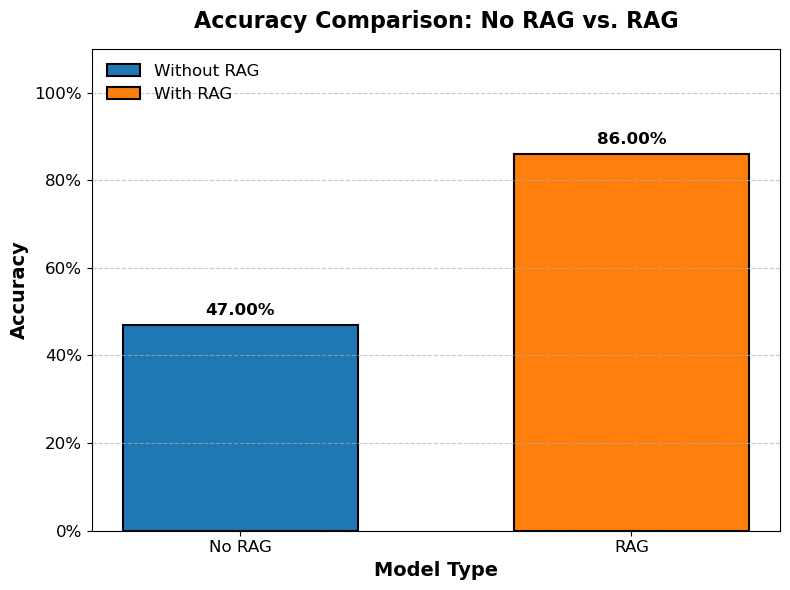

In [ ]:
labels = ["No RAG", "RAG"]
accuracy = [no_rag_accuracy, rag_accuracy]

fig, ax = plt.subplots(figsize=(8, 6))
bar_colors = ["#1f77b4", "#ff7f0e"]
bar_width = 0.6

bars = ax.bar(
    labels,
    accuracy,
    color=bar_colors,
    width=bar_width,
    edgecolor="black",
    linewidth=1.5,
)

for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.2%}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
        fontweight="bold",
    )

ax.grid(axis="y", linestyle="--", alpha=0.7)

ax.set_ylabel("Accuracy", fontsize=14, fontweight="bold")
ax.set_xlabel("Model Type", fontsize=14, fontweight="bold")
ax.set_title(
    "Accuracy Comparison: No RAG vs. RAG", fontsize=16, fontweight="bold", pad=15
)

ax.set_ylim(0, 1.1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([f"{int(x * 100)}%" for x in np.linspace(0, 1, 6)], fontsize=12)

ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.legend(
    bars, ["Without RAG", "With RAG"], loc="upper left", fontsize=12, frameon=False
)

plt.tight_layout()
plt.show()

## Pipeline Description

We extended the Retrieval Augmented Generation (RAG) by implementing a comprehensive multi-step pipeline:

### 1. Named Entity Recognition Classification (NERC)

-   Tool: Spacy (`en_core_web_sm` model)
-   Evaluation: Larger and alternative architectures were tested but yielded negligible performance improvements.
-   Optimized Entity Tags:
    -   `PERSON`
    -   `GPE`
    -   `LOC`
    -   `NORP`

### 2. Enhanced Wikipedia Page Extraction

-   Context: Focused on the 2022 U.S. midterm elections dataset.
-   Method:
    -   Augmented entity extraction from step 1 by incorporating search queries related to elections (e.g., district, governor race).
    -   Applied regex query _(case-insensitive)_:
        ```regex
        won the (.*? in the 2022)
        ```

### 3. Wikipedia Content Ranking

-   Metric: Cosine similarity with respect to the question.
-   Retention: Only kept the top `MAX_TEXTS_TO_KEEP`.

### 4. Vector Database Construction

-   Tool: `langchain`'s `RecursiveCharacterTextSplitter`.
-   Optimization:
    -   Tested various `chunk_size` values.
    -   Best result achieved with `chunk_size=500`.

### 5. Prompting the Large Language Model (LLM)

-   Approaches:
    1. No-RAG: Direct LLM prompting using only the question and options.
    2. RAG: Added relevant Wikipedia context from the vector database to the prompt.
-   Optimization: Domain-specific prompt engineering for both approaches.

### Note on Data Quality

Manual inspection revealed inconsistencies in the provided gold standard:

-   Some multi-choice options contained duplicated entries.
-   Resolution: Merged duplicate entries to ensure consistency.

---

## Analysis of the Results

### Key Findings:

-   RAG Performance: 86% accuracy, significantly outperforming the No-RAG approach (47% accuracy).
-   Insights:
    -   Contextual Wikipedia data in RAG enhanced factual accuracy and the LLM's ability to identify the correct option.
    -   Even with the introduction of some noise, providing actual election results improved performance.

### Sensitivity:

The obtained results are sensitive to the inherent variability of the utilized LLM.

---

*The results demonstrate the effectiveness of Retrieval-Augmented Generation in leveraging domain-specific factual information for improved accuracy.*
